In [1]:
########################################################################
########################################################################
##                                                                    ##
##                      ORIGINAL _ DO NOT PUBLISH                     ##
##                                                                    ##
########################################################################
########################################################################

import torch as tr
import torch
from torch.nn.functional import pad
import torch.nn as nn
import numpy as np
import loader as ld
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


batch_size = 32
output_size = 2
hidden_size = 8        # to experiment with

run_recurrent = True    # else run Token-wise MLP
use_RNN = False          # otherwise GRU
atten_size = 0          # atten > 0 means using restricted self atten

reload_model = False
num_epochs = 10
learning_rate = 0.0001
test_interval = 300

# Loading sataset, use toy = True for obtaining a smaller dataset

train_dataset, test_dataset, num_words, input_size = ld.get_data_set(batch_size)

# Special matrix multipication layer (like torch.Linear but can operate on arbitrary sized
# tensors and considers its last two indices as the matrix.)

class MatMul(nn.Module):
    def __init__(self, in_channels, out_channels, use_bias = True):
        super(MatMul, self).__init__()
        self.matrix = torch.nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(in_channels,out_channels)), requires_grad=True)
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros(1,1,out_channels), requires_grad=True)

        self.use_bias = use_bias

    def forward(self, x):        
        x = torch.matmul(x,self.matrix) 
        if self.use_bias:
            x = x+ self.bias 
        return x


class ExRestSelfAtten(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, atten_size=5):
        super(ExRestSelfAtten, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.sqrt_hidden_size = np.sqrt(float(hidden_size))
        self.ReLU = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=2)
        self.atten_size = atten_size
        
        # Token-wise MLP + Restricted Attention network implementation
        self.layer1 = MatMul(input_size, hidden_size)
        self.W_q = MatMul(hidden_size, hidden_size, use_bias=False)
        self.W_k = MatMul(hidden_size, hidden_size, use_bias=False)
        self.W_v = MatMul(hidden_size, hidden_size, use_bias=False)
        self.layer2 = MatMul(hidden_size, output_size)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(batch_size, num_words, input_size))

    def name(self):
        return "MLP_atten"

    def forward(self, x):
        # Add positional encoding
        x = x + self.positional_encoding[:x.shape[0],:,:]

        # Token-wise MLP + Restricted Attention network implementation
        x = self.layer1(x)
        x = self.ReLU(x)

        # generating x in offsets between -atten_size and atten_size 
        # with zero padding at the ends
        padded = pad(x, (0, 0, self.atten_size, self.atten_size, 0, 0))

        x_nei = []
        for k in range(-self.atten_size, self.atten_size + 1):
            x_nei.append(torch.roll(padded, k, 1))

        x_nei = torch.stack(x_nei, 2)
        x_nei = x_nei[:, self.atten_size:-self.atten_size, :]

        # Applying attention layer
        queries = self.W_q(x).unsqueeze(2)
        keys = self.W_k(x_nei)
        values = self.W_v(x_nei)

        # Compute attention scores
        atten_scores = torch.matmul(queries, keys.transpose(-2, -1)) / self.sqrt_hidden_size
        atten_weights = self.softmax(atten_scores)

        # Apply attention weights
        atten_output = torch.matmul(atten_weights, values).squeeze(2)

        # Pass through final linear layer
        output = self.layer2(atten_output)

        return output, atten_weights


# prints portion of the review (20-30 first words), with the sub-scores each work obtained
# prints also the final scores, the softmaxed prediction values and the true label values

def print_review(rev_text, sbs1, sbs2, lbl1, lbl2):
    print(' '.join(rev_text))
    print('word\t\tprediction\tlabel')
    for i in range(len(rev_text)):
        print(f'{rev_text[i]}\t\t{"1" if bool(sbs1[i] > sbs2[i]) else "0"}\t{"1" if bool(lbl1 > lbl2) else "0"}')

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext

Using model: MLP_atten
Epoch [1/10], Step [300/938], Train Loss: 0.8457, Test Loss: 0.8625
Epoch [1/10], Step [600/938], Train Loss: 0.6873, Test Loss: 0.7178
Epoch [1/10], Step [900/938], Train Loss: 0.6444, Test Loss: 0.6846
Accuracy: 0.4791666666666667
Epoch [2/10], Step [300/938], Train Loss: 0.6249, Test Loss: 0.6727
Epoch [2/10], Step [600/938], Train Loss: 0.7436, Test Loss: 0.6904
Epoch [2/10], Step [900/938], Train Loss: 0.6537, Test Loss: 0.6767
Accuracy: 0.6354166666666666
Epoch [3/10], Step [300/938], Train Loss: 0.6816, Test Loss: 0.6010
Epoch [3/10], Step [600/938], Train Loss: 0.5826, Test Loss: 0.6283
Epoch [3/10], Step [900/938], Train Loss: 0.6984, Test Loss: 0.5805
Accuracy: 0.75
Epoch [4/10], Step [300/938], Train Loss: 0.6621, Test Loss: 0.6113
Epoch [4/10], Step [600/938], Train Loss: 0.5747, Test Loss: 0.6194
Epoch [4/10], Step [900/938], Train Loss: 0.6210, Test Loss: 0.6409
Accuracy: 0.6354166666666666
Epoch [5/10], Step [300/938], Train Loss: 0.6781, Test Loss

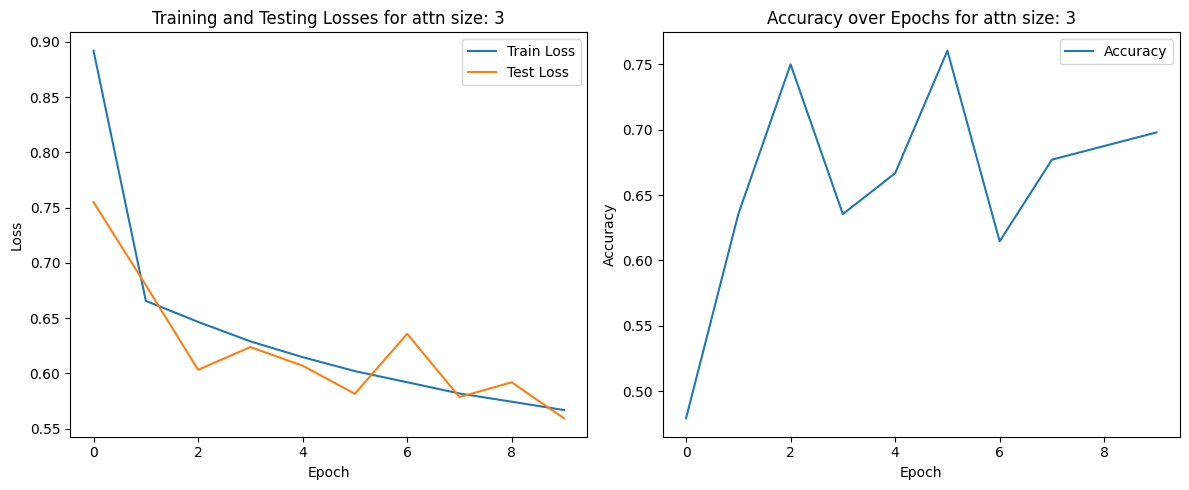

Using model: MLP_atten
Epoch [1/10], Step [300/938], Train Loss: 0.9148, Test Loss: 0.9857
Epoch [1/10], Step [600/938], Train Loss: 0.7655, Test Loss: 0.8095
Epoch [1/10], Step [900/938], Train Loss: 0.7111, Test Loss: 0.7854
Accuracy: 0.4583333333333333
Epoch [2/10], Step [300/938], Train Loss: 0.8028, Test Loss: 0.6318
Epoch [2/10], Step [600/938], Train Loss: 0.6589, Test Loss: 0.6944
Epoch [2/10], Step [900/938], Train Loss: 0.6181, Test Loss: 0.6765
Accuracy: 0.6145833333333334
Epoch [3/10], Step [300/938], Train Loss: 0.6827, Test Loss: 0.6786
Epoch [3/10], Step [600/938], Train Loss: 0.6872, Test Loss: 0.6009
Epoch [3/10], Step [900/938], Train Loss: 0.7073, Test Loss: 0.7420
Accuracy: 0.5833333333333334
Epoch [4/10], Step [300/938], Train Loss: 0.6948, Test Loss: 0.6176
Epoch [4/10], Step [600/938], Train Loss: 0.7183, Test Loss: 0.6650
Epoch [4/10], Step [900/938], Train Loss: 0.6385, Test Loss: 0.6576
Accuracy: 0.6666666666666666
Epoch [5/10], Step [300/938], Train Loss: 0.6

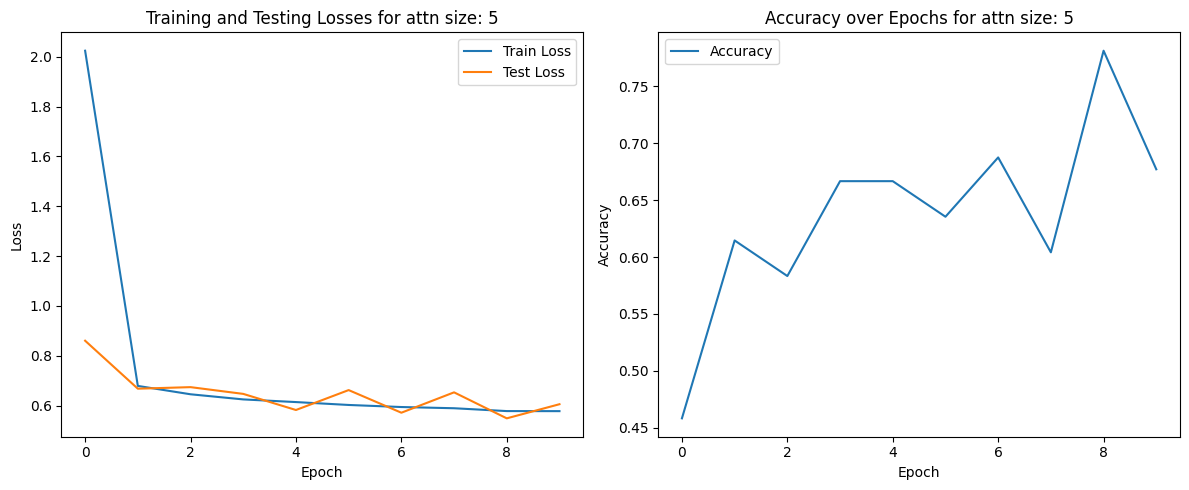

Using model: MLP_atten
Epoch [1/10], Step [300/938], Train Loss: 0.9421, Test Loss: 1.1114
Epoch [1/10], Step [600/938], Train Loss: 0.8265, Test Loss: 0.9081
Epoch [1/10], Step [900/938], Train Loss: 0.7182, Test Loss: 0.7036
Accuracy: 0.4270833333333333
Epoch [2/10], Step [300/938], Train Loss: 0.7324, Test Loss: 0.7814
Epoch [2/10], Step [600/938], Train Loss: 0.7739, Test Loss: 0.5698
Epoch [2/10], Step [900/938], Train Loss: 0.6247, Test Loss: 0.7614
Accuracy: 0.5416666666666666
Epoch [3/10], Step [300/938], Train Loss: 0.7349, Test Loss: 0.7618
Epoch [3/10], Step [600/938], Train Loss: 0.6197, Test Loss: 0.6690
Epoch [3/10], Step [900/938], Train Loss: 0.5818, Test Loss: 0.7413
Accuracy: 0.5520833333333334
Epoch [4/10], Step [300/938], Train Loss: 0.6335, Test Loss: 0.6764
Epoch [4/10], Step [600/938], Train Loss: 0.7394, Test Loss: 0.6384
Epoch [4/10], Step [900/938], Train Loss: 0.5496, Test Loss: 0.6553
Accuracy: 0.6145833333333334
Epoch [5/10], Step [300/938], Train Loss: 0.6

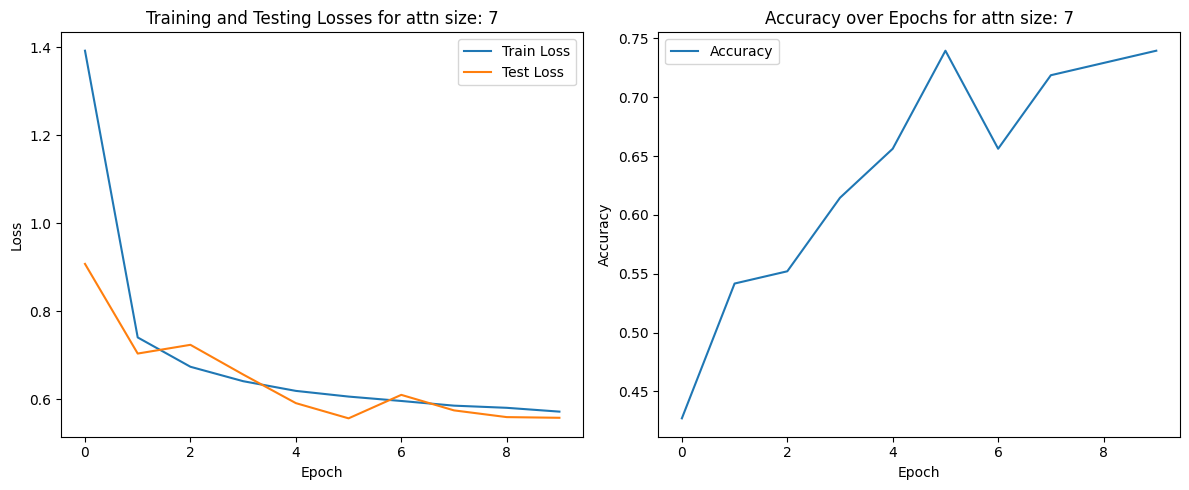

In [2]:
for atten_size in  [3,5,7]:

    model = ExRestSelfAtten(input_size, output_size, hidden_size, atten_size)

    print("Using model: " + model.name())

    if reload_model:
        print("Reloading model")
        model.load_state_dict(torch.load(model.name() + ".pth"))

    model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = 1.0
    test_loss = 1.0

    # training steps in which a test step is executed every test_interval

    model.train()

    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(num_epochs):

        itr = 0 # iteration counter within each epoch
        epoch_train_loss = 0
        epoch_test_loss = 0
        epoch_accuracies = []

        for labels, reviews, reviews_text in train_dataset:   # getting training batches

            # test if the model can predict allways False
            # labels = torch.arange(0, 2, dtype=torch.float32).repeat(1024,1).cuda()

            itr = itr + 1

            if (itr + 1) % test_interval == 0:
                test_iter = True
                labels, reviews, reviews_text = next(iter(test_dataset)) # get a test batch 
            else:
                test_iter = False

            # Recurrent nets (RNN/GRU)

            # Token-wise networks (MLP / MLP + Atten.) 

            sub_score, atten_weights = model(reviews)

            output = torch.mean(sub_score, 1)
                
            # cross-entropy loss

            loss = criterion(output, labels)

            # optimize in training iterations

            if not test_iter:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # averaged losses
            if test_iter:
                test_loss = 0.8 * float(loss.detach()) + 0.2 * test_loss
                epoch_test_loss += test_loss
            else:
                train_loss = 0.9 * float(loss.detach()) + 0.1 * train_loss
                epoch_train_loss += train_loss

            if test_iter:
                accuracy = accuracy_score(torch.argmax(output, dim=1).cpu(), torch.argmax(labels, dim=1).cpu())
                epoch_accuracies.append(accuracy)
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}], "
                    f"Step [{itr + 1}/{len(train_dataset)}], "
                    f"Train Loss: {train_loss:.4f}, "
                    f"Test Loss: {test_loss:.4f}"
                )

                if not run_recurrent:
                    nump_subs = sub_score.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    print_review(reviews_text[0], nump_subs[0,:,0], nump_subs[0,:,1], labels[0,0], labels[0,1])

                # saving the model
                torch.save(model, model.name() + "_" + str(atten_size) + ".pth")

        print(f"Accuracy: {sum(epoch_accuracies) / len(epoch_accuracies)}")
        accuracies.append(sum(epoch_accuracies) / len(epoch_accuracies))    
        train_losses.append(epoch_train_loss / len(train_dataset))
        test_losses.append(epoch_test_loss / (len(train_dataset) // test_interval))


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Testing Losses for attn size: {atten_size}')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(accuracies)), accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Accuracy over Epochs for attn size: {atten_size}')

    plt.tight_layout()
    plt.show()

In [8]:
import pandas as pd
all_reviews = pd.read_csv('IMDB Dataset.csv')

In [15]:
from loader import preprocess_review, MAX_LENGTH, tokinize

for idx, record in all_reviews.iterrows():

    review_hard_for_rnn_rep = preprocess_review(record['review']).cuda()

    attn_model = torch.load("MLP_atten_7.pth")

    attn_model.eval()

    with torch.no_grad():
        sub_score, _ = attn_model(review_hard_for_rnn_rep)
        output = torch.mean(sub_score.squeeze(), 0)

    attn_pred = "positive" if output[0] > output[1] else "negative"

    if attn_pred != record['sentiment']:
        if attn_pred == 'negative':
            print(f"ATTN: {attn_pred}, label: {record['sentiment']}, record: {record['review']}")
            nump_subs = sub_score.squeeze().cpu().detach().numpy()
            print_review(tokinize(record['review']), nump_subs[:,0], nump_subs[:,1], bool(record['sentiment'] == 'positive'), bool(record['sentiment'] == 'negative'))
            break

ATTN: negative, label: positive, record: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the 

In [13]:
from loader import preprocess_review, MAX_LENGTH, tokinize

for idx, record in all_reviews.iterrows():

    review_hard_for_rnn_rep = preprocess_review(record['review']).cuda()

    attn_model = torch.load("MLP_atten_7.pth")

    attn_model.eval()

    with torch.no_grad():
        sub_score, _ = attn_model(review_hard_for_rnn_rep)
        output = torch.mean(sub_score.squeeze(), 0)

    attn_pred = "positive" if output[0] > output[1] else "negative"

    if attn_pred == record['sentiment']:
        if attn_pred == 'positive':
            print(f"ATTN: {attn_pred}, label: {record['sentiment']}, record: {record['review']}")
            nump_subs = sub_score.squeeze().cpu().detach().numpy()
            print_review(tokinize(record['review']), nump_subs[:,0], nump_subs[:,1], bool(record['sentiment'] == 'positive'), bool(record['sentiment'] == 'negative'))
            break

ATTN: positive, label: positive, record: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating

In [14]:
from loader import preprocess_review, MAX_LENGTH, tokinize

for idx, record in all_reviews.iterrows():

    review_hard_for_rnn_rep = preprocess_review(record['review']).cuda()

    attn_model = torch.load("MLP_atten_7.pth")

    attn_model.eval()

    with torch.no_grad():
        sub_score, _ = attn_model(review_hard_for_rnn_rep)
        output = torch.mean(sub_score.squeeze(), 0)

    attn_pred = "positive" if output[0] > output[1] else "negative"

    if attn_pred == record['sentiment']:
        if attn_pred == 'negative':
            print(f"ATTN: {attn_pred}, label: {record['sentiment']}, record: {record['review']}")
            nump_subs = sub_score.squeeze().cpu().detach().numpy()
            print_review(tokinize(record['review']), nump_subs[:,0], nump_subs[:,1], bool(record['sentiment'] == 'positive'), bool(record['sentiment'] == 'negative'))
            break

ATTN: negative, label: negative, record: Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.
basically there a family where little boy jake thinks there a zombie in his closet his parents are fighting all the time br br this movie is slower than soap opera and suddenly jake decides to become rambo and 

In [18]:
class ExMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExMLP, self).__init__()

        self.Sigmoid = torch.nn.Sigmoid()

        # Token-wise MLP network weights
        self.layer1 = MatMul(input_size,hidden_size)
        self.layer2 = MatMul(hidden_size,output_size)
        # additional layer(s)
        

    def name(self):
        return "MLP"

    def forward(self, x):

        # Token-wise MLP network implementation
        
        x = self.layer1(x)
        x = self.Sigmoid(x)
        x = self.layer2(x)
        x = self.Sigmoid(x)
        # rest

        return x

In [22]:
from loader import preprocess_review, MAX_LENGTH, tokinize

cnt = 0

for idx, record in all_reviews.iterrows():

    review_hard_for_rnn_rep = preprocess_review(record['review']).cuda()

    attn_model = torch.load("MLP_atten_7.pth")

    attn_model.eval()

    with torch.no_grad():
        attn_sub_score, _ = attn_model(review_hard_for_rnn_rep)
        output = torch.mean(attn_sub_score.squeeze(), 0)

    attn_pred = "positive" if output[0] > output[1] else "negative"

    mlp_model = torch.load("MLP_16.pth")

    mlp_model.eval()

    with torch.no_grad():
        mlp_sub_score = mlp_model(review_hard_for_rnn_rep)
        output = torch.mean(mlp_sub_score.squeeze(), 0)

    mlp_pred = "positive" if output[0] > output[1] else "negative"

    if mlp_pred != attn_pred:
        if attn_pred == record['sentiment']:
            print(f"MLP: {mlp_pred}, ATTN: {attn_pred}, label: {record['sentiment']}, record: {record['review']}")
            mlp_nump_subs = mlp_sub_score.squeeze().cpu().detach().numpy()
            attn_nump_subs = attn_sub_score.squeeze().cpu().detach().numpy()
            print('MLP')
            print_review(tokinize(record['review']), mlp_nump_subs[:,0], mlp_nump_subs[:,1], bool(record['sentiment'] == 'positive'), bool(record['sentiment'] == 'negative'))
            print('ATTN')
            print_review(tokinize(record['review']), attn_nump_subs[:,0], attn_nump_subs[:,1], bool(record['sentiment'] == 'positive'), bool(record['sentiment'] == 'negative'))
            cnt += 1
            if cnt > 3:
                break

MLP: negative, ATTN: positive, label: positive, record: Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find